In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from pprint import pprint
from scipy.stats import linregress
from scipy import stats
import json


# Import API key
from api_keys2 import climate_api

#parse the datetimes we get from NOAA
from datetime import datetime

#Cedar Park, TX weather station
station_id =str('GHCND:USR0000TCED')


In [2]:
# Weather API Website -> NOAA
base_url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data?"

#creating parameters with ID (Global Summaries over Month), Temperature Max, limit of 1000, weather station, temperature convert to Fahrenheit. 
params = {
    "datasetid" : "GSOM",
    "datatyepid" : "TMAX",
    "limit" : "1000",
    "stationid" : station_id,
    "units" : "standard"
}

#have to create header to make API call with API Token Key
headers = {
    "token":climate_api
}


In [47]:
#create lists to store data
dates_temp = []
dates_prcp = []
temps = []
prcp = []

#create year average temperature list
years = range(2000,2020)
year_avgs = []

#for each year from 2000 to 2020 every 5 years
for year in range(2000,2020):
    year = str(year)
    print('working on year '+year)
    tavg = []
    
    #add to my params for start and end date
    params['startdate'] = year + '-01-01'
    params['enddate'] = year + '-12-31'
    
    #make the api call
    r = requests.get(base_url,params = params, headers=headers)
    
    #load the api response as a json
    d = json.loads(r.text)
    
    #get all items in the response which are average temperature readings
    avg_temps = [item for item in d['results'] if item['datatype']=='TMAX']
    
    #get the date field from all average temperature readings
    dates_temp += [item['date'] for item in avg_temps]
    
    #get the actual average temperature from all average temperature readings
    temps += [item['value'] for item in avg_temps]
    tavg += [item['value'] for item in avg_temps]
    
    #get the year average over the entire year to compare with bee data
    year_avgs.append(sum(tavg) / len(tavg))
    
print(year_avgs)    

working on year 2000
working on year 2001
working on year 2002
working on year 2003
working on year 2004
working on year 2005
working on year 2006
working on year 2007
working on year 2008
working on year 2009
working on year 2010
working on year 2011
working on year 2012
working on year 2013
working on year 2014
working on year 2015
working on year 2016
working on year 2017
working on year 2018
working on year 2019
[75.42500000000001, 74.93333333333335, 73.2, 74.91666666666667, 73.28333333333333, 74.35000000000001, 76.46666666666665, 72.575, 74.19166666666668, 73.93333333333334, 74.14999999999999, 76.85000000000001, 77.47499999999998, 74.675, 74.30833333333332, 75.60909090909091, 76.11666666666666, 75.44999999999999, 75.26666666666667, 73.00833333333333]


In [4]:
#create dataframe
df_temp = pd.DataFrame()
df_year = pd.DataFrame()

#populate date and average temperature fields (cast string date to datetime and create column for temperature (already in F))
df_temp['date'] = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in dates_temp]
df_temp['avgTemp'] = [float(v) for v in temps]

df_year['date'] = years
df_year['year_avg'] = year_avgs

In [5]:
df_year.head()

,date,year_avg
0,2000,75.425000
1,2001,74.933333
2,2002,73.200000
3,2003,74.916667
4,2004,73.283333


In [14]:
#create lists to store data for every 4 years
fdates_temp = []
dates_prcp = []
four_temps = []
prcp = []


#for each year from 2000 to 2020 every 4 years
for year in range(2000,2020,4):
    year = str(year)
    print('working on year '+year)
    t4avg = []
    
    #add to my params for start and end date
    params['startdate'] = year + '-01-01'
    params['enddate'] = year + '-12-31'
    
    #make the api call
    r = requests.get(base_url,params = params, headers=headers)
    
    #load the api response as a json
    d = json.loads(r.text)
    
    #get all items in the response which are average temperature readings
    avg4_temps = [item for item in d['results'] if item['datatype']=='TMAX']
    
    #get the date field from all average temperature readings
    fdates_temp += [item['date'] for item in avg4_temps]
    
    #get the actual average temperature from all average temperature readings
    four_temps += [item['value'] for item in avg4_temps]
    t4avg += [item['value'] for item in avg4_temps]


working on year 2000
working on year 2004
working on year 2008
working on year 2012
working on year 2016


In [16]:
#create dataframe for every four years
df_four = pd.DataFrame()

#populate date and average temperature fields (cast string date to datetime and create column for temperature (already in F))
df_four['date'] = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in fdates_temp]
df_four['avgTemp'] = [float(v) for v in four_temps]

df_four.count()

date       60
avgTemp    60
dtype: int64

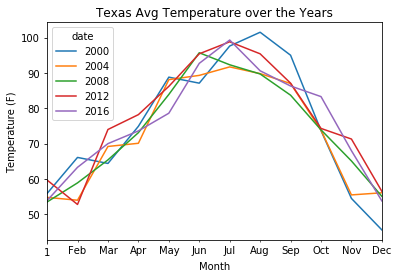

In [31]:
#group by year and date
date = pd.Index(df_four["date"])
df2 = df_four["avgTemp"].groupby([date.year, date]).mean()

#shift all year to 2000 -> consistent date and no leap year
date = df2.index.get_level_values(1)
new_date = pd.Index(pd.io.date_converters.parse_date_fields(np.ones(len(date))*2000, date.month, date.day))
year = df2.index.get_level_values(0)
df2.index = pd.MultiIndex.from_arrays([year, new_date])

#plot line graph
p = df2.unstack(0).plot()
p.xaxis.set_ticklabels(range(1, 13))
p.set_xlabel('Month')
p.set_title('Texas Avg Temperature over the Years')
p.set_ylabel('Temperature (F)')

#save and show graph
plt.savefig('output_images/temp_fouryear.png', bbox_inches='tight')
plt.show()

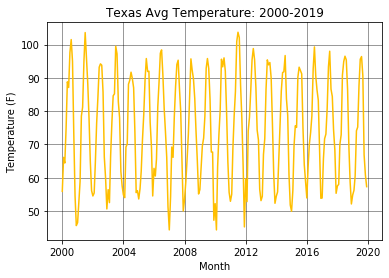

In [53]:
#Texas Avg Temp through out 2000 - 2019
date = df_temp["date"]
temp = df_temp["avgTemp"]

#create graph
plt.plot(date,temp, color = '#ffbf00')
plt.grid(color = 'black',alpha = .5, axis='both')
plt.xlabel('Month')
plt.title('Texas Avg Temperature: 2000-2019')
plt.ylabel('Temperature (F)')
plt.axis('tight')

#save and show graph
plt.savefig('output_images/texas_avgtemp.png', bbox_inches='tight')
plt.show()

In [10]:
#extracting honey csv
honey_file = "honey_data.csv"

#convert csv to data frame
honey_data = pd.read_csv(honey_file)
honey_data.head()

,Unnamed: 0,Year,State,Commodity,Data Type,Value
0,0,2019,US TOTAL,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",2812000
1,1,2018,US TOTAL,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",2828000
2,2,2017,US TOTAL,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",2684000
3,3,2016,US TOTAL,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",2780000
4,4,2015,US TOTAL,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",2661000


In [11]:
#extracting colony data for Texas and for 2000 - 2019
honey_tx = honey_data.loc[(honey_data["State"] == 'TEXAS') & (honey_data["Year"] >= 2000), :]
honey_tx.head()

,Unnamed: 0,Year,State,Commodity,Data Type,Value
1177,1177,2019,TEXAS,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",126000
1178,1178,2018,TEXAS,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",132000
1179,1179,2017,TEXAS,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",120000
1180,1180,2016,TEXAS,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",133000
1181,1181,2015,TEXAS,HONEY,"HONEY, BEE COLONIES - INVENTORY, MEASURED IN C...",126000


In [55]:
#define my Temperature and Bees function from the different data sets
temp = df_year['year_avg']
bee = honey_tx['Value']               

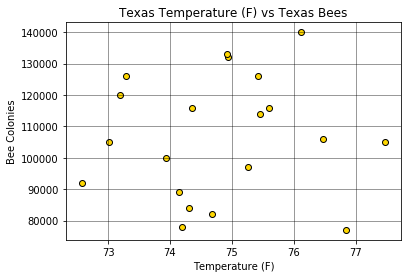

In [56]:
#assign variables via lineregress function
#vc_slope, vc_int, vc_r, vc_p, vc_std_err = linregress(temp, bee)

plt.grid(color = 'black',alpha = .5, axis='both')
plt.scatter(temp,bee,c='gold', edgecolors = 'black')
plt.xlabel('Temperature (F)')
plt.ylabel('Bee Colonies')
plt.title('Texas Temperature (F) vs Texas Bees')
#plt.figure(figsize=[10,10])

#display r-squared
#print(f"The r-squared is: {vc_r}")

plt.savefig('output_images/temp_bee_scatter.png', bbox_inches='tight')
plt.show()

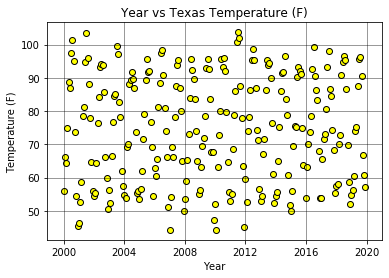

In [57]:
temp = df_temp['avgTemp']
date = df_temp['date']

#vc_slope, vc_int, vc_r, vc_p, vc_std_err = linregress(date, temp)

plt.grid(color = 'black',alpha = .5, axis='both')
plt.scatter(date,temp,c='yellow', edgecolors = 'black')
plt.xlabel('Year')
plt.ylabel('Temperature (F)')
plt.title('Year vs Texas Temperature (F)')
plt.show()
